# Real-time tracking

SQLiteTracker provides a powerful and flexible way to track computational (e.g., Machine Learning) experiments using an SQLite database.

This tutorial demonstrates training a small network on the Fashion MNIST dataset and tracking the training and validation metrics in real time. We would also see how you can query the tracked metrics while training is ongoing and visualize the metrics vs. epoch plots.

## Create the experiment tracker

In [1]:
from pathlib import Path

db = Path("nn_experiments.db")
if db.exists():
    db.unlink()

In [2]:
from sklearn_evaluation import SQLiteTracker

tracker = SQLiteTracker("nn_experiments.db")
experiment = tracker.new_experiment()
uuid = experiment.uuid

## MNIST Dataset

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

In [3]:
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

2023-03-07 18:31:13.027265: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 18:31:13.153856: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-07 18:31:13.153880: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2023-03-07 18:31:14.012876: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-07 18:31:14.013009: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-07 18:31:14.013019: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


 8192/29515 [=======>......................] - ETA: 0s

29515/29515 [==============================] - 0s 1us/step


    8192/26421880 [..............................] - ETA: 0s

  114688/26421880 [..............................] - ETA: 11s

  802816/26421880 [..............................] - ETA: 3s 

 4374528/26421880 [===>..........................] - ETA: 0s

 8626176/26421880 [========>.....................] - ETA: 0s

12976128/26421880 [=============>................] - ETA: 0s

17350656/26421880 [==================>...........] - ETA: 0s

21790720/26421880 [=======================>......] - ETA: 0s

26230784/26421880 [============================>.] - ETA: 0s

26421880/26421880 [==============================] - 0s 0us/step


5148/5148 [==============================] - 0s 0us/step


   8192/4422102 [..............................] - ETA: 0s

 114688/4422102 [..............................] - ETA: 1s

 794624/4422102 [====>.........................] - ETA: 0s

4382720/4422102 [============================>.] - ETA: 0s

4422102/4422102 [==============================] - 0s 0us/step


In [4]:
# create a validation set
from sklearn.model_selection import train_test_split

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2
)

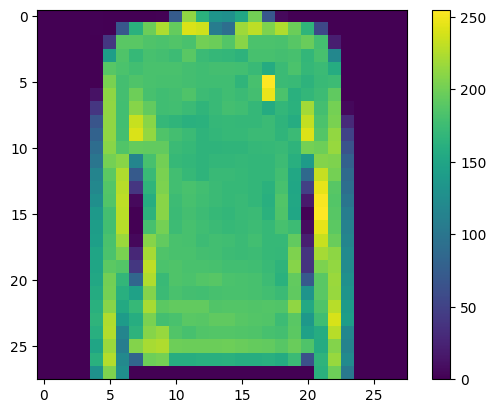

In [5]:
# Inspect an image in the dataset (Pixel values fall in the range 0-255)
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [6]:
train_images = train_images[:500]
train_labels = train_labels[:500]
val_images = val_images[:500]
val_labels = val_labels[:500]

In [7]:
# Scale the images to range (0,1)

train_images = train_images / 255.0
val_images = val_images / 255.0

## Train the model

In [8]:
# Create all metrics arrays

loss = []
val_loss = []
accuracy = []
val_accuracy = []

Define a callback that will track the metrics during the training, and log in the experiment tracker.

In [9]:
class TrackLossandAccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss.append(logs["loss"])
        val_loss.append(logs["val_loss"])
        accuracy.append(logs["accuracy"])
        val_accuracy.append(logs["val_accuracy"])
        tracker.upsert(
            uuid,
            {
                "loss": loss,
                "accuracy": accuracy,
                "val_loss": val_loss,
                "val_accuracy": val_accuracy,
            },
        )

In [10]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(10),
    ]
)

2023-03-07 18:31:16.695371: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-07 18:31:16.695410: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-07 18:31:16.695440: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (build-19703864-project-622891-sklearn-evaluation): /proc/driver/nvidia/version does not exist
2023-03-07 18:31:16.695683: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [12]:
epoch_count = 10
history = model.fit(
    train_images,
    train_labels,
    validation_data=(val_images, val_labels),
    epochs=epoch_count,
    verbose=0,
    callbacks=[TrackLossandAccuracyCallback()],
)

## Track metrics while training

While the training is ongoing, you may visualize the metrics plot by opening another terminal/notebook and running the steps below.

Query the experiment with SQL:

In [13]:
results = tracker.query(
    """
SELECT
    uuid,
    json_extract(parameters, '$.accuracy') as accuracy,
    json_extract(parameters, '$.loss') as loss,
    json_extract(parameters, '$.val_accuracy') as val_accuracy,
    json_extract(parameters, '$.val_loss') as val_loss
    FROM experiments
"""
)

Extract and plot the relevant metrics against epochs:

In [14]:
import json

training_accuracy = json.loads(results["accuracy"].to_list()[0])
val_accuracy = json.loads(results["val_accuracy"].to_list()[0])
training_loss = json.loads(results["loss"].to_list()[0])
val_loss = json.loads(results["val_loss"].to_list()[0])

epoch_range = range(1, len(training_accuracy) + 1)

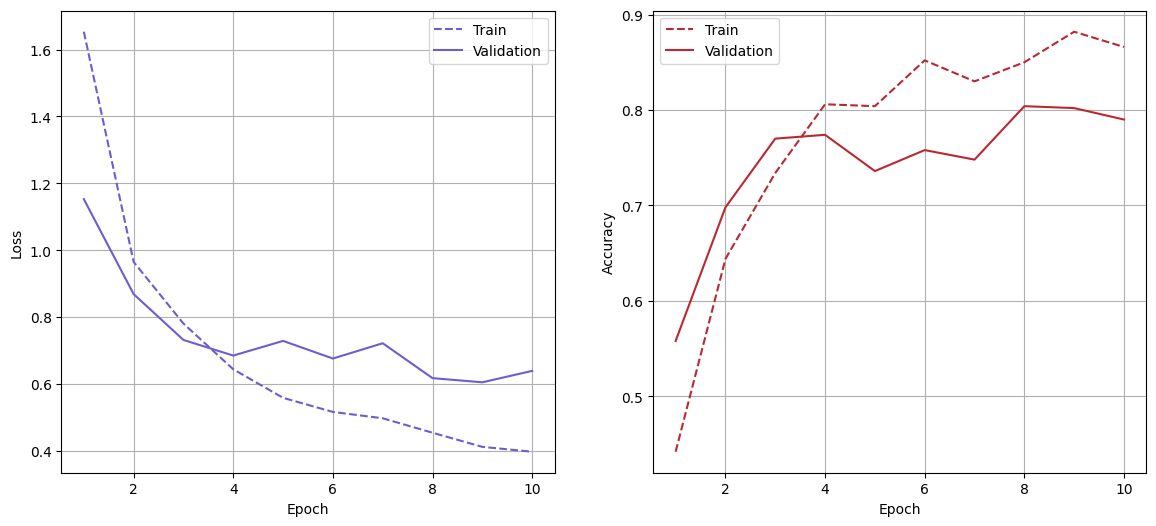

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(epoch_range, training_loss, color="#725BD0", linestyle="--", label="Train")
ax1.plot(epoch_range, val_loss, color="#725BD0", linestyle="-", label="Validation")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend(loc="best")
ax1.grid()

ax2.plot(epoch_range, training_accuracy, color="#BA2932", linestyle="--", label="Train")
ax2.plot(epoch_range, val_accuracy, color="#BA2932", linestyle="-", label="Validation")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend(loc="best")
ax2.grid()